# Load DeepFly3D Data

In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict, reprojection_error, intrinsic_matrix
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# declare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', #mac/ubuntu path format
              #'data_dir'       : r'\Users\NeLy\Desktop\fly_tether', #windows path format
               'out_dir'        : '/data/LiftPose3D/fly_tether/angle_inv_network',
               'train_subjects' : [1,2,3,4,5],
               'test_subjects'  : [6,7],
               'actions'        : ['all'],
               'cam_id'         : [0,6]}

#these don't need to be set as long as 'pose_2d=True' in lp3d_train() below
#intr = intrinsic_matrix(171.0 * 94.0, 171.0 * 94.0, 240, 480) 
#intr = {0: intr,1: intr}
#tvec = {0: np.array([0, 0, 117]), 1: np.array([0, 0, 117])}

training_kwargs = {'eangles': {0: [[-30,-20], [-2, 2], [-2,2]], 6: [[-270,-250], [-2, 2], [-2,2]]},
                   'axsorder': 'yxz',
                   'vis': {0: [1 if i<15 else 0 for i in range(30)], 6: [0 if i<15 else 1 for i in range(30)]},
                   'tvec': None,
                   'intr': None}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, test_keypts, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Train LiftPose3D Network on DeepFly3D Data

In [2]:
from liftpose.preprocess import obtain_projected_stats
    
stats = obtain_projected_stats(train_3d,
                               training_kwargs['eangles'], 
                               training_kwargs['axsorder'], 
                               training_kwargs['vis'],
                               training_kwargs['tvec'],
                               training_kwargs['intr'],
                               par['roots'], 
                               par['target_sets'],
                               par['out_dir'],
                               load_existing=False,
                               th=1)

[preprocess.py:447]:INFO:Bootstrapping mean and variance...
[preprocess.py:534]:INFO:Expected error for obtaining projection stats: 16.62036605751829
[preprocess.py:534]:INFO:Expected error for obtaining projection stats: 0.0009022052107972771


In [3]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project

aug = random_project(**training_kwargs)

lp3d_train(train_2d=None, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":10},
           augmentation=[aug],
           stats=stats,
           norm_2d=True
          )

/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:201: RuntimeWarning: invalid value encountered in true_divide
  tmp /= np.linalg.norm(tmp, ord='fro', axis=(1,2), keepdims=True)


[main.py:239]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/angle_inv_network/stat_2d.pth.tar.
[main.py:258]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/angle_inv_network/stat_3d.pth.tar.
[main.py:286]:INFO:Starting training model.
[main.py:297]:DEBUG:
==================Options=================
[main.py:298]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'out_dir': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:299]:DEBUG:==========================================

[lift.

Epoch 000 | LR  0.00081 | Loss Test  0.00000 | Loss Train  0.07958|: 100%|██████████| 11051/11051 [01:26<00:00, 127.41it/s]
Epoch 001 | LR  0.00066 | Loss Test  0.06588 | Loss Train  0.04004|: 100%|██████████| 11051/11051 [01:27<00:00, 125.91it/s]
Epoch 002 | LR  0.00053 | Loss Test  0.06624 | Loss Train  0.03654|: 100%|██████████| 11051/11051 [01:28<00:00, 125.30it/s]
Epoch 003 | LR  0.00043 | Loss Test  0.06376 | Loss Train  0.03453|: 100%|██████████| 11051/11051 [01:28<00:00, 124.52it/s]
Epoch 004 | LR  0.00031 | Loss Test  0.06424 | Loss Train  0.03322|: 100%|██████████| 11051/11051 [01:29<00:00, 124.06it/s]
Epoch 005 | LR  0.00025 | Loss Test  0.06337 | Loss Train  0.03227|: 100%|██████████| 11051/11051 [01:29<00:00, 124.08it/s]
Epoch 006 | LR  0.00021 | Loss Test  0.06458 | Loss Train  0.03151|: 100%|██████████| 11051/11051 [01:29<00:00, 123.14it/s]
Epoch 007 | LR  0.00017 | Loss Test  0.06205 | Loss Train  0.03097|: 100%|██████████| 11051/11051 [01:30<00:00, 122.47it/s]
Epoch 00

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


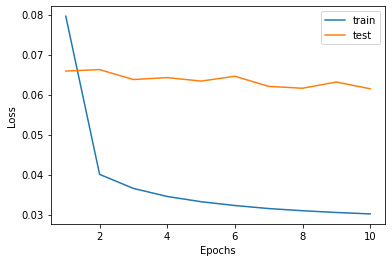

In [4]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [13]:
from liftpose.postprocess import load_test_results
from liftpose.preprocess import concat_dict
from liftpose.main import set_test_data
from liftpose.main import test as lp3d_test
from liftpose.lifter.utils import filter_data

test_3d_gt, test_3d_pred, good_keypts = [], [], []
for cam in par["cam_id"]:
    
    #load test data
    test_2d = load_2D(par["data_dir"],par,cam_id=[cam],subjects=par["test_subjects"],actions=par["actions"])
    test_3d, kp, rcams_test = load_3D(par["data_dir"],par,cam_id=[cam],subjects=par["test_subjects"],actions=par["actions"])
    
    #normalize test data
    test_2d, test_3d, stat_2d, stat_3d = set_test_data(par['out_dir'], test_2d, test_3d, kp.copy(), norm_2d=True)
    
    #test data on network
    lp3d_test(par["out_dir"],test_2d, test_3d, kp.copy())
    
    #load statistics and test results
    gt, pred, _ = load_test_results(par['out_dir'], stat_2d, stat_3d)
    
    kp = concat_dict(kp)
    gt[~kp] = 0
    pred[~kp] = 0
    
    test_3d_gt.append(gt)
    test_3d_pred.append(pred)
    good_keypts.append(kp)
    
test_3d_gt = test_3d_gt[0] + test_3d_gt[1]
test_3d_pred = test_3d_pred[0] + test_3d_pred[1]
good_keypts = good_keypts[0] + good_keypts[1]

#filter noise
test_3d_gt = filter_data(test_3d_gt)
test_3d_pred = filter_data(test_3d_pred)


[main.py:392]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/angle_inv_network
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:56]:INFO:total params: 4.33M
[lift.py:64]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/angle_inv_network/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 9 | err: 0.029152286982798998)
[lift.py:106]:INFO:Saving results: /data/LiftPose3D/fly_tether/angle_inv_network/test_results.pth.tar
[main.py:392]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/angle_inv_network
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:56]:INFO:total params: 4.33M
[lift.py:64]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/angle_inv_network/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 9 | err: 0.029152286982798998)
[lift.py:106]:INFO:Saving results: /data/LiftPose3D/fly_tether/angle_inv_network/test_results.pth.tar


# Visualize Predictions

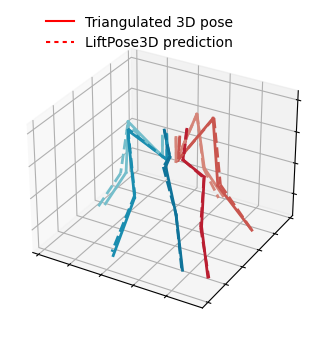

In [14]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d
from scipy.spatial.transform import Rotation as Rot

t = 0

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

R = Rot.from_euler('xyz', [-np.pi/2, 0, 0], degrees=False).as_matrix()
tar = np.matmul(R,test_3d_gt[t].T).T
pred = np.matmul(R,test_3d_pred[t].T).T

plot_pose_3d(ax=ax, tar=tar, 
            pred=pred,
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            legend=True)

# Video

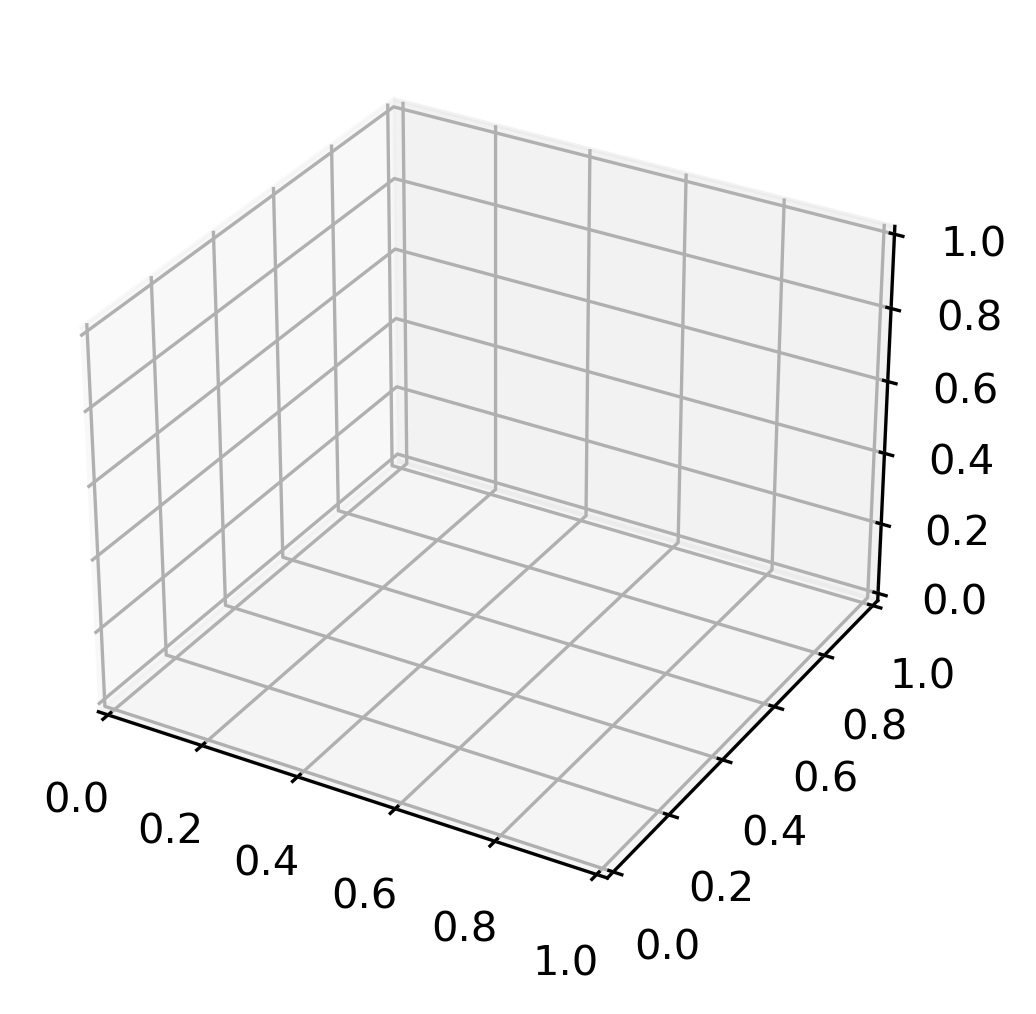

In [15]:
from liftpose.plot import plot_video_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=300)
ax = fig.add_subplot(111, projection='3d')

def f(ax, idx):
    ax.cla()
    R = Rot.from_euler('xyz', [-np.pi/2, 0, 0], degrees=False).as_matrix()
    tar = np.matmul(R,test_3d_gt[idx].T).T
    pred = np.matmul(R,test_3d_pred[idx].T).T
    plot_pose_3d(ax=ax, tar=tar,
        pred=pred,
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"], 
        normalize=True,
        legend=True)
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-1.5,0.5])
    
plot_video_3d(fig, ax, n=900, fps=20, draw_function=f, name='LiftPose3D_prediction.mp4')